# maxsmi
## Analysis of results

This notebook serves to analyse the results of the simulations ran on the Curta cluster.

## Prerequisites
This notebook will run under the condition that some simulations have been run, e.g.
```
(maxsmi) $ python maxsmi/full_workflow.py --task ESOL --aug-strategy-train augmentation_with_duplication --aug-nb-train 10 --aug-nb-test 10

```

Have a look at the [README](https://github.com/t-kimber/maxsmi/blob/main/README.md) page for more details.

We are looking to answer these questions:

1. Does augmentation improve performance independently of the model ?
2. Does the performance (only/strictly) increase with augmentation or does it reach a plateau ?
3. What is the best augmentation strategy ?
4. Can the model learn the inherent symmetry of the molecules using controlled duplication ?

In [1]:
#  !pip install flake8 pycodestyle_magic
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
from maxsmi.utils_analysis import retrieve_metric
import matplotlib.pyplot as plt

In [3]:
def plot_metric(metric="r2", set_="test",
                max_augmentation=100,
                step=10,
                start=0):
    """
    Plots the metric of interest on the set of interest.

    Parameters
    ----------
    metric : str, default r2
        The metric of interest, such as the r2 score,
        time or mean squared error.
    set_ : str, default test
        The train set or test set.
    augmentation_strategy : str
            The augmentation strategy used.
    max_augmentation : int, default is 100.
        The largest number of augmentation that was performed.
    step : int, default 10
        The step in the augmentation number.
    start : int
        Which augmentation number to start with.
        If 0, no augmentation is taken into account.

    Returns
    -------
    None
    """
    tasks = ["ESOL", "free_solv", "lipophilicity"]
    models = ["CONV1D", "CONV2D", "RNN"]

    fig, ax = plt.subplots(nrows=len(tasks),
                           ncols=len(models),
                           figsize=(20, 20))

    for j, model in enumerate(models):
        for i, task in enumerate(tasks):
            legend_ = []
            if task != "lipophilicity":
                for augmentation_strategy in [
                    "augmentation_with_duplication",
                    "augmentation_without_duplication",
                    "augmentation_with_reduced_duplication"
                ]:
                    x = [elem for elem in range(start,
                                                max_augmentation+step, step)]
                    y_task_model_strategy = []
                    for augmentation_num in range(start,
                                                  max_augmentation+step, step):
                        y = retrieve_metric(
                            metric,
                            set_,
                            task,
                            augmentation_strategy,
                            augmentation_num,
                            augmentation_strategy,
                            augmentation_num,
                            model,
                        )
                        y_task_model_strategy.append(y)
                    ax[i, j].plot(x, y_task_model_strategy)
                    ax[i, j].set_title(f"{task}:{model}")
                    ax[i, j].set_xlabel("Number of augmentation")
                    ax[i, j].set_ylabel(f"{metric}")
                    if metric == "r2":
                        # ax[i, j].set_ylim([0.82, 1])
                        ax[i, j].set_ylim([0.5, 1])
                        ax[i, j].set_xlim([start-1, max_augmentation+1])
                        ax[i, j].set_xticks([elem for elem in
                                             range(start,
                                                   max_augmentation+step,
                                                   step)])
                    caption = f"{augmentation_strategy}"
                    legend_.append(caption)
                    ax[i, j].legend(legend_)
            if task == "lipophilicity":
                augmentation_strategy = "augmentation_without_duplication"
                y_task_model_strategy = []
                x = [elem for elem in range(start,
                                            50, step)]
                for augmentation_num in range(start,
                                              50, step):
                    y = retrieve_metric(
                        metric,
                        set_,
                        task,
                        augmentation_strategy,
                        augmentation_num,
                        augmentation_strategy,
                        augmentation_num,
                        model,
                    )
                    y_task_model_strategy.append(y)
                ax[i, j].plot(x, y_task_model_strategy)
                ax[i, j].set_title(f"{task}:{model}")
                ax[i, j].set_xlabel("Number of augmentation")
                ax[i, j].set_ylabel(f"{metric}")
                if metric == "r2":
                    # ax[i, j].set_ylim([0.82, 1])
                    ax[i, j].set_ylim([0.3, 1])
                    ax[i, j].set_xlim([start-1, 100+1])
                caption = f"{augmentation_strategy}"
                legend_.append(caption)
                ax[i, j].legend(legend_)
    fig.suptitle(f"Metric {metric} on {set_} set "
                 f"for all datasets and all models",
                 fontsize=20)
    plt.show()

### 1. Does augmentation improve performance independently of the model ?

#### Answer:

Yes. Given the plots below, all types of augmentation are better w.r.t. to no augmentation, for all models.

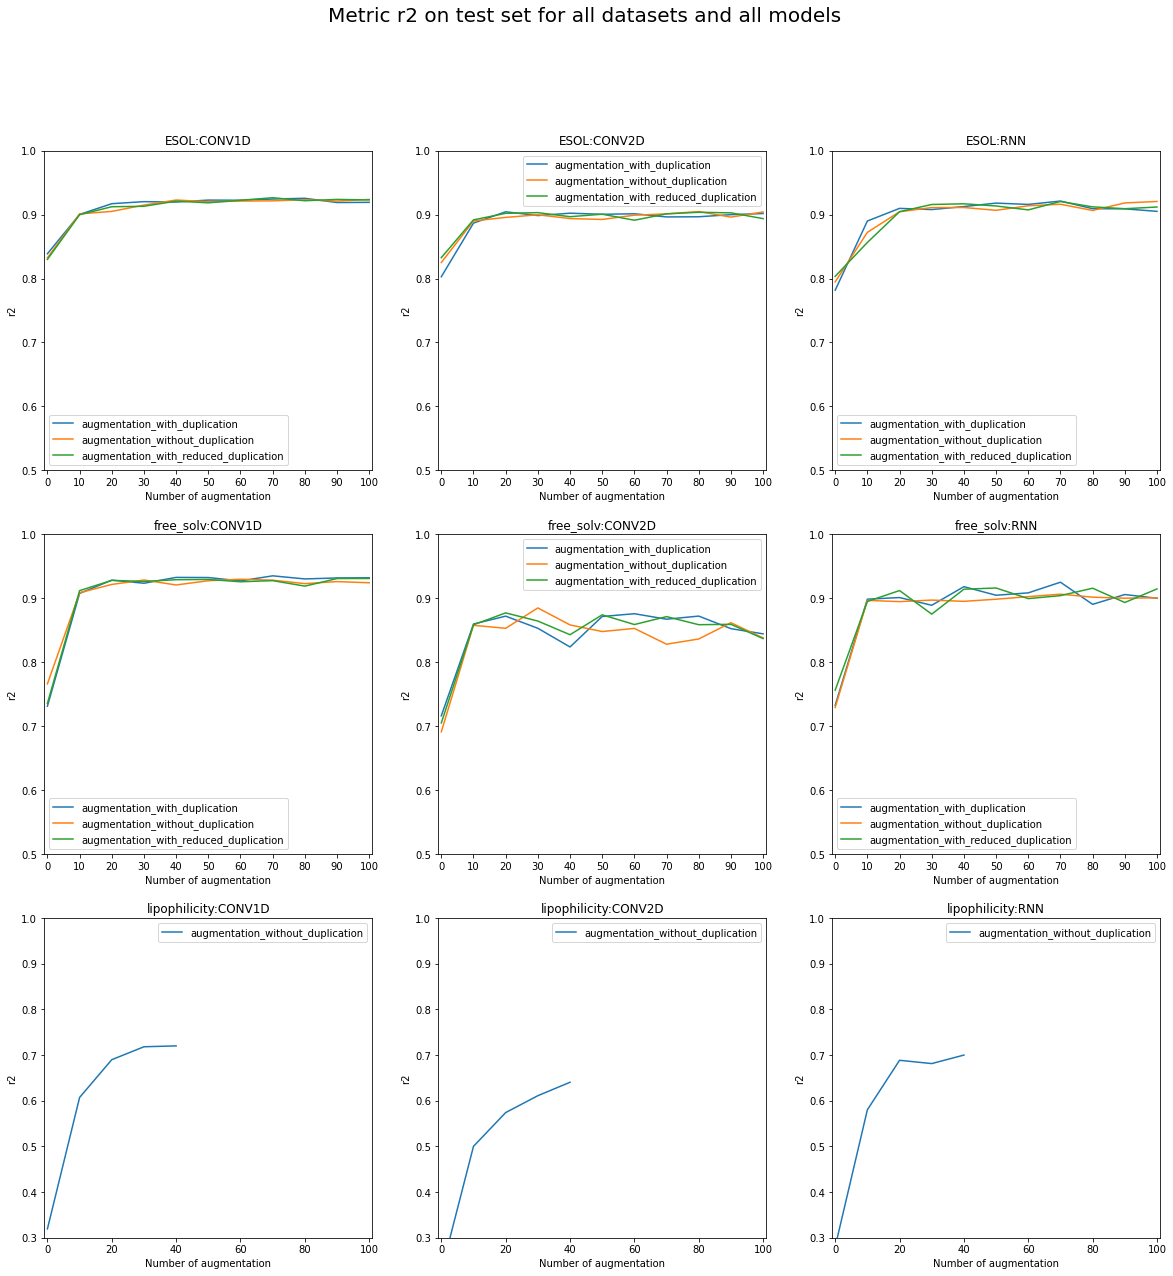

In [4]:
plot_metric("r2", "test")

### 2. Does the performance (only/strictly) increase with augmentation or does it reach a plateau ?

#### Answer

It seems to reach a plateau and it seems that around 10-20, the plateau is reached in most cases.

#### Follow up question:

How about doing a finer augmentation, i.e. instead of
$$
0, 10, 20, ..., 100,
$$
try
$$
0, 1, 2, ..., 20.
$$ 

### 3. What is the best augmentation strategy ?

#### Answer

There isn't one strategy which stands out as being _the_ best. But from a purely numerical point of view, we have:


For ESOL:
- model CONV1D: augmentation_with_reduced_duplication, 70, 0.926
- model CONV2D: augmentation_with_duplication, 20, 0.906
- model RNN: augmentation_with_duplication, 70, 0.921
- model CONV1D: augmentation_maximum_estimation, 0.910

So for ESOL, the best setting is : **model CONV1D: augmentation_with_reduced_duplication, 70, 0.926**

For free_solv:
- model CONV1D: augmentation_with_duplication, 70, 0.935
- model CONV2D: augmentation_without_duplication, 30, 0.885
- model RNN: augmentation_with_duplication, 70, 0.925

For free_solv, the best setting is : **model CONV1D: augmentation_with_duplication, 70, 0.935**


### 4. Can the model learn the inherent symmetry of the molecules using controlled duplication ? (or augmentation with duplication?)

#### Answer

Yes, it seems that the mean prediction error is smaller for symmetric molecules if augmentation used. Analysis to be continued!

### Appendix

The plot below shows how training time evolves with respect to augmentation.

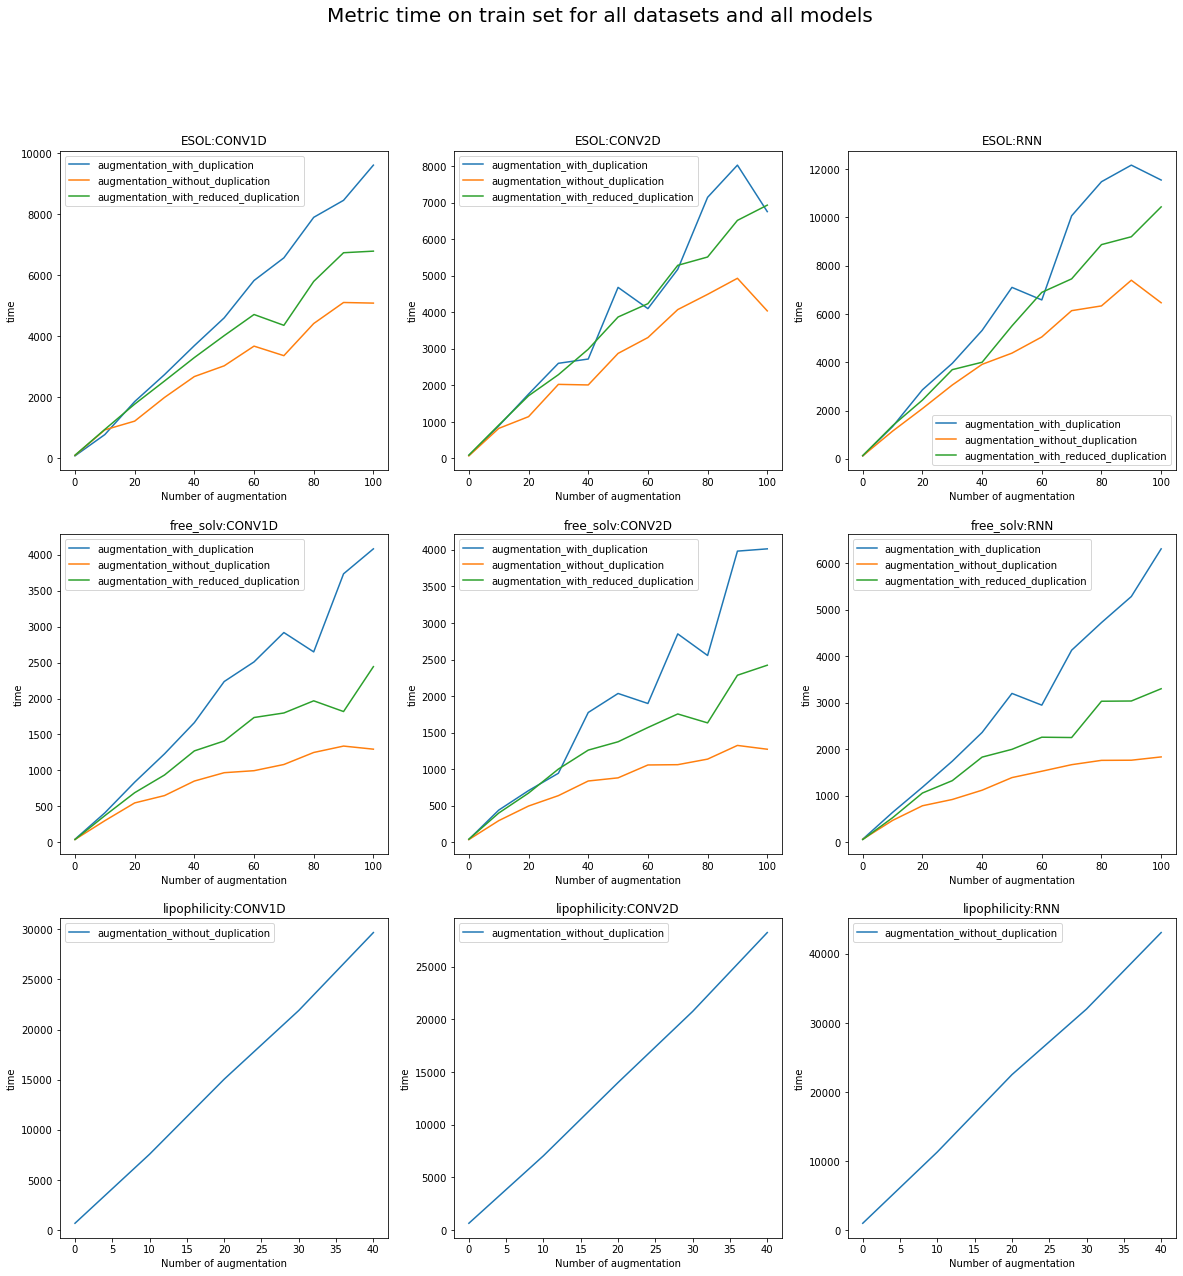

In [5]:
plot_metric("time", "train")